In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from openpyxl import load_workbook

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

Создание датафрейма из таблицы с объемом кредитов

In [36]:
df =  pd.read_excel('stat_bulletin_lending_24-01_45.xlsx', sheet_name = 'Таблица 1', skiprows = 2)
df.to_csv("Test.csv")
replace_text = ' '
for i in range(1, len(df.columns)): 
    if df.columns[i] == 'Unnamed: ' + str(i):
        if count==0:
            replace_text = df.columns.values[i-1] 
            df.columns.values[i-1] = df.columns.values[i-1] + '<>' + df.iloc[0][i-1]
        df.columns.values[i] = replace_text + '<>' + df.iloc[0][i]
        count += 1
    else:
        count = 0

df = df.drop(0, axis = 0)
df.head()

C:\Users\Дарья\AppData\Local\Temp\ipykernel_12364\509607299.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.columns.values[i-1] = df.columns.values[i-1] + '<>' + df.iloc[0][i-1]
C:\Users\Дарья\AppData\Local\Temp\ipykernel_12364\509607299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.columns.values[i] = replace_text + '<>' + df.iloc[0][i]


,Отчетный период,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в рублях","Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в иностранной валюте","Количество кредитов, предоставленных субъектам МСП, в рублях и иностранной валюте, ед.","Средний размер кредита субъектов МСП, млн руб.","Количество субъектов МСП, получивших кредит в отчетном месяце, ед."
1,Январь 2022 г.,800529,798524,2006,181204.0,4.4,163871.0
2,Февраль 2022 г.,964639,960168,4471,201384.0,4.8,179660.0
3,Март 2022 г.,816031,815581,450,171437.0,4.8,157676.0
4,Апрель 2022 г.,808912,784373,24539,166472.0,4.9,151661.0
5,Май 2022 г.,676283,663850,12433,167614.0,4.0,152422.0


In [37]:
df['Отчетный период'] = df['Отчетный период'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 1 to 25
Data columns (total 7 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   Отчетный период                                                                            25 non-null     object 
 1   Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего                             25 non-null     object 
 2   Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в рублях              25 non-null     object 
 3   Объем кредитов, предоставленных субъектам МСП, млн руб.<>в том числе в иностранной валюте  25 non-null     object 
 4   Количество кредитов, предоставленных субъектам МСП, в рублях и иностранной валюте, ед.     25 non-null     float64
 5   Средний размер кредита субъектов МСП, млн руб.       

In [38]:
df = df[['Отчетный период', 'Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']]
df = df.reset_index()
df = df.drop('index', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column                                                          Non-Null Count  Dtype 
---  ------                                                          --------------  ----- 
 0   Отчетный период                                                 25 non-null     object
 1   Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего  25 non-null     object
dtypes: object(2)
memory usage: 532.0+ bytes


Создание датафрейма из таблицы с макропараметрами

In [39]:
df_par =  pd.read_excel('2. Макро_базовый.xlsx', skiprows = 4)
df_par.to_csv("Test2.csv")
df_par = df_par.drop('Unnamed: 1', axis = 1)
df_par = df_par.transpose()
df_par = df_par.reset_index()
df_par.rename(columns = {'index': 'Отчетный период'}, inplace = True)
df_par = df_par.drop(0, axis = 1)

for i in range(1, len(df_par.columns)): 
    if df_par.iloc[0][i] == '* ВВП в 2022 году учитывает экономическую активность, связанную с новыми территориями ** Показатели будут уточнены по мере выхода официальной статистической информации по Донецкой Народной Республике (ДНР), Луганской  Народной Республике (ЛНР), Запорожской и Херсонской областям в соответствии с Федеральным планом статистических работ, утвержденным распоряжением Правительства Российской Федерации от 6 мая 2008 г. № 671-р':
        df_par = df_par.drop(i, axis = 1)
    if df_par.iloc[0][i] == '** Показатели будут уточнены по мере выхода официальной статистической информации по Донецкой Народной Республике (ДНР), Луганской  Народной Республике (ЛНР), Запорожской и Херсонской областям в соответствии с Федеральным планом статистических работ, утвержденным распоряжением Правительства Российской Федерации от 6 мая 2008 г. № 671-р':
        df_par = df_par.drop(i, axis = 1)
    

    
column_names_par = df_par.columns.tolist()
replace_text_par = ' '
for i in range(1, len(df_par.columns)): 
    if pd.isna(df_par.iloc[1][i]):
        replace_text_par = df_par.iloc[0][i]
        column_names_par[i] = 'Delete' + str(i)
    else:
        if i>1 and i < (len(df_par.columns) - 7):
            column_names_par[i] = replace_text_par + '<>' + df_par.iloc[0][i]
        else:
            column_names_par[i] = df_par.iloc[0][i]

df_par = df_par.drop(0, axis = 0)
df_par.columns = column_names_par
            
df_par = df_par[[col for col in df_par.columns if not col.startswith('Delete')]]      
df_par

,Отчетный период,"Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,...,Торговый баланс<> к ВВП,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС
1,2022,79.6195,111.94,113.75,153435,153435.1528,97.9,115.8,102547.556,100.6,...,13.8101,236.0771,10.3789,74.9242,71.9736,2.9507,3.9382,97.5543,67.4562,3470.052542
2,2023,63.4057,107.534,105.8115,166015.075882,163981.9275,102.8295,103.933,108951.6706,103.57284,...,7.5524,74.3564,3.8643,75.1515,72.7994,2.3521,3.1298,101.6631,85.2212,4125.595338
3,2024,71.3111,104.5421,107.1615,179956.175591,177557.0605,102.2589,105.8865,121532.7169,102.553429,...,7.6805,80.7495,4.0987,75.6172,73.2651,2.3521,3.1106,101.6088,90.1244,4301.15374
4,2025,70.1012,104.0395,104.1663,190637.073105,187854.0996,102.2632,103.4578,127837.6622,102.213447,...,7.4833,77.7687,3.7726,76.109,73.7568,2.3521,3.0905,101.5814,91.1288,4088.02769
5,2026,70.0166,104.004,104.0099,202303.750996,199131.1612,102.2416,103.679,134474.087,102.286358,...,7.4695,80.8226,3.7453,76.3457,73.9936,2.352,3.0808,101.9144,92.2776,4438.995763


In [40]:
# Создаем список для хранения данных 
all_rows = []

# Итерируемся по строкам (годам) в исходном DataFrame
for j in range(len(df_par) - 1):
    # Итерируемся по месяцам в обратном порядке
    for month in range(12, 0, -1):
        # Создаем словарь для хранения данных за месяц
        row = {'Отчетный период': pd.to_datetime(f"{df_par.iloc[j, 0]}-{month:02d}")}

        # Итерируемся по столбцам (показателям)
        for i in range(1, len(df_par.columns)):
            # Получаем имя столбца
            col_name = df_par.columns[i]

            # Значение за январь текущего года (принимаем за базу)
            start_value = float(df_par.iloc[j, i])

            # Разница между значениями за два года
            difference = float(df_par.iloc[j + 1, i] - start_value)

            # Вычисляем значение для текущего месяца
            value = start_value + (difference / 12) * (12 - month)

            # Добавляем значение в словарь row
            row[col_name] = value

        # Добавляем словарь в список всех строк
        all_rows.append(row)

# Создаем DataFrame из списка словарей
df_monthly = pd.DataFrame(all_rows, columns = df_par.columns)

# Сортируем DataFrame по дате
df_monthly = df_monthly.sort_values(by='Отчетный период').reset_index(drop=True)
df_monthly.head()

,Отчетный период,"Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,...,Торговый баланс<> к ВВП,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС
0,2022-01-01,64.75685,107.901167,106.473042,164966.736225,163103.029608,102.418708,104.921917,108417.994383,103.325103,...,8.073875,87.833125,4.407183,75.132558,72.730583,2.401983,3.197167,101.3207,83.740783,4070.966771
1,2022-02-01,66.10800,108.268333,107.134583,163918.396568,162224.131717,102.007917,105.910833,107884.318167,103.077367,...,8.595350,101.309850,4.950067,75.113617,72.661767,2.451867,3.264533,100.9783,82.260367,4016.338205
2,2022-03-01,67.45915,108.635500,107.796125,162870.056911,161345.233825,101.597125,106.899750,107350.641950,102.829630,...,9.116825,114.786575,5.492950,75.094675,72.592950,2.501750,3.331900,100.6359,80.779950,3961.709639
3,2022-04-01,68.81030,109.002667,108.457667,161821.717255,160466.335933,101.186333,107.888667,106816.965733,102.581893,...,9.638300,128.263300,6.035833,75.075733,72.524133,2.551633,3.399267,100.2935,79.299533,3907.081072
4,2022-05-01,70.16145,109.369833,109.119208,160773.377598,159587.438042,100.775542,108.877583,106283.289517,102.334157,...,10.159775,141.740025,6.578717,75.056792,72.455317,2.601517,3.466633,99.9511,77.819117,3852.452506


Разобъем эти данные на выборку для прогноза и данные для дальнейшего обучения и тестирования

In [41]:
split_date = '2024-01-01'
train = df_monthly[df_monthly['Отчетный период'] <= split_date]
train = train.drop('Отчетный период', axis = 1)
data_for_predict = df_monthly[df_monthly['Отчетный период'] > split_date]
# Преобразуем столбец 'date' в формат datetime
data_for_predict['Отчетный период'] = pd.to_datetime(data_for_predict['Отчетный период'])
# Извлекаем номер месяца 
data_for_predict['Месяц'] = data_for_predict['Отчетный период'].dt.month
data_for_predict_in_memory = data_for_predict
data_for_predict = data_for_predict.drop('Отчетный период', axis = 1)
data_for_predict

C:\Users\Дарья\AppData\Local\Temp\ipykernel_12364\1294975347.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_predict['Отчетный период'] = pd.to_datetime(data_for_predict['Отчетный период'])
C:\Users\Дарья\AppData\Local\Temp\ipykernel_12364\1294975347.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_predict['Месяц'] = data_for_predict['Отчетный период'].dt.month


,"Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,Объем отгруженной продукции (работ. услуг) <> Индекс-дефлятор (по сопоставимому кругу предприятий),...,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС,Месяц
25,70.302850,104.123267,104.665500,188856.923519,186137.926417,102.262483,103.862583,126786.837983,102.270111,103.886667,...,78.265500,3.826950,76.027033,73.674850,2.352100,3.093850,101.585967,90.961400,4123.548698,2
26,70.403675,104.165150,104.915100,187966.848727,185279.839825,102.262125,104.064975,126261.425875,102.298443,104.375000,...,78.513900,3.854125,75.986050,73.633875,2.352100,3.095525,101.588250,90.877700,4141.309202,3
27,70.504500,104.207033,105.164700,187076.773934,184421.753233,102.261767,104.267367,125736.013767,102.326774,104.863333,...,78.762300,3.881300,75.945067,73.592900,2.352100,3.097200,101.590533,90.794000,4159.069706,4
28,70.605325,104.248917,105.414300,186186.699141,183563.666642,102.261408,104.469758,125210.601658,102.355106,105.351667,...,79.010700,3.908475,75.904083,73.551925,2.352100,3.098875,101.592817,90.710300,4176.830211,5
29,70.706150,104.290800,105.663900,185296.624348,182705.580050,102.261050,104.672150,124685.189550,102.383438,105.840000,...,79.259100,3.935650,75.863100,73.510950,2.352100,3.100550,101.595100,90.626600,4194.590715,6
30,70.806975,104.332683,105.913500,184406.549555,181847.493458,102.260692,104.874542,124159.777442,102.411770,106.328333,...,79.507500,3.962825,75.822117,73.469975,2.352100,3.102225,101.597383,90.542900,4212.351219,7
31,70.907800,104.374567,106.163100,183516.474762,180989.406867,102.260333,105.076933,123634.365333,102.440101,106.816667,...,79.755900,3.990000,75.781133,73.429000,2.352100,3.103900,101.599667,90.459200,4230.111723,8
32,71.008625,104.416450,106.412700,182626.399969,180131.320275,102.259975,105.279325,123108.953225,102.468433,107.305000,...,80.004300,4.017175,75.740150,73.388025,2.352100,3.105575,101.601950,90.375500,4247.872227,9
33,71.109450,104.458333,106.662300,181736.325176,179273.233683,102.259617,105.481717,122583.541117,102.496765,107.793333,...,80.252700,4.044350,75.699167,73.347050,2.352100,3.107250,101.604233,90.291800,4265.632732,10
34,71.210275,104.500217,106.911900,180846.250384,178415.147092,102.259258,105.684108,122058.129008,102.525097,108.281667,...,80.501100,4.071525,75.658183,73.306075,2.352100,3.108925,101.606517,90.208100,4283.393236,11


Объединим датафрейм с данными об объеме кредита с датафреймом с данными о макропараметрах

In [42]:
df_total = pd.concat([df, train], axis = 1)
df_total.head()

,Отчетный период,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,...,Торговый баланс<> к ВВП,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС
0,Январь 2022 г.,800529,64.75685,107.901167,106.473042,164966.736225,163103.029608,102.418708,104.921917,108417.994383,...,8.073875,87.833125,4.407183,75.132558,72.730583,2.401983,3.197167,101.3207,83.740783,4070.966771
1,Февраль 2022 г.,964639,66.10800,108.268333,107.134583,163918.396568,162224.131717,102.007917,105.910833,107884.318167,...,8.595350,101.309850,4.950067,75.113617,72.661767,2.451867,3.264533,100.9783,82.260367,4016.338205
2,Март 2022 г.,816031,67.45915,108.635500,107.796125,162870.056911,161345.233825,101.597125,106.899750,107350.641950,...,9.116825,114.786575,5.492950,75.094675,72.592950,2.501750,3.331900,100.6359,80.779950,3961.709639
3,Апрель 2022 г.,808912,68.81030,109.002667,108.457667,161821.717255,160466.335933,101.186333,107.888667,106816.965733,...,9.638300,128.263300,6.035833,75.075733,72.524133,2.551633,3.399267,100.2935,79.299533,3907.081072
4,Май 2022 г.,676283,70.16145,109.369833,109.119208,160773.377598,159587.438042,100.775542,108.877583,106283.289517,...,10.159775,141.740025,6.578717,75.056792,72.455317,2.601517,3.466633,99.9511,77.819117,3852.452506


In [43]:
month_mapping = {
    'Январь': 1,
    'Февраль': 2,
    'Март': 3,
    'Апрель': 4,
    'Май': 5,
    'Июнь': 6,
    'Июль': 7,
    'Август': 8,
    'Сентябрь': 9,
    'Октябрь': 10,
    'Ноябрь': 11,
    'Декабрь': 12
}

df_total['Месяц'] = df_total['Отчетный период'].str.split(' ').str[0].map(month_mapping)
df_total = df_total.drop('Отчетный период', axis = 1)
df_total.head()

,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,...,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС,Месяц
0,800529,64.75685,107.901167,106.473042,164966.736225,163103.029608,102.418708,104.921917,108417.994383,103.325103,...,87.833125,4.407183,75.132558,72.730583,2.401983,3.197167,101.3207,83.740783,4070.966771,1
1,964639,66.10800,108.268333,107.134583,163918.396568,162224.131717,102.007917,105.910833,107884.318167,103.077367,...,101.309850,4.950067,75.113617,72.661767,2.451867,3.264533,100.9783,82.260367,4016.338205,2
2,816031,67.45915,108.635500,107.796125,162870.056911,161345.233825,101.597125,106.899750,107350.641950,102.829630,...,114.786575,5.492950,75.094675,72.592950,2.501750,3.331900,100.6359,80.779950,3961.709639,3
3,808912,68.81030,109.002667,108.457667,161821.717255,160466.335933,101.186333,107.888667,106816.965733,102.581893,...,128.263300,6.035833,75.075733,72.524133,2.551633,3.399267,100.2935,79.299533,3907.081072,4
4,676283,70.16145,109.369833,109.119208,160773.377598,159587.438042,100.775542,108.877583,106283.289517,102.334157,...,141.740025,6.578717,75.056792,72.455317,2.601517,3.466633,99.9511,77.819117,3852.452506,5


In [44]:
df_total.corr()

,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего","Экспортная цена на российскую нефть, долл. за баррель",Индекс потребительских цен<> на конец года,Индекс потребительских цен<> в среднем за год,Валовой внутренний продукт <> Номинальный объем,Валовой внутренний продукт <> Номинальный объем (85 субъектов),Валовой внутренний продукт <> Темп роста,Валовой внутренний продукт <> Индекс-дефлятор ВВП,Объем отгруженной продукции (работ. услуг) <> Номинальный объем,Объем отгруженной продукции (работ. услуг) <> Индекс промышленного производства,...,Счет текущих операций<> Номинальное значение,Счет текущих операций<> к ВВП,Численность рабочей силы,Численность занятых в экономике,Общая численность безработных граждан,Уровень безработицы,Производительность труда,Курс доллара США,Госкапвложения БС,Месяц
"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего",1.000000,-0.366538,-0.160439,-0.276394,0.085015,0.070526,0.305179,-0.294948,0.045411,0.359058,...,-0.287365,-0.283622,0.014537,0.141406,-0.280767,-0.273534,0.284148,0.222520,0.253528,0.652899
"Экспортная цена на российскую нефть, долл. за баррель",-0.366538,1.000000,0.649623,0.899869,-0.503393,-0.470738,-0.927062,0.923355,-0.404626,-0.987727,...,0.898568,0.894299,-0.348886,-0.630168,0.885657,0.874507,-0.891120,-0.778311,-0.810323,0.245740
Индекс потребительских цен<> на конец года,-0.160439,0.649623,1.000000,0.897345,-0.972214,-0.963533,-0.885350,0.888094,-0.950726,-0.727277,...,0.916336,0.920840,-0.907031,-0.988750,0.926853,0.936079,-0.922081,-0.982776,-0.951865,0.543239
Индекс потребительских цен<> в среднем за год,-0.276394,0.899869,0.897345,1.000000,-0.825652,-0.804586,-0.981145,0.995639,-0.755578,-0.919484,...,0.983608,0.985913,-0.722422,-0.902134,0.980980,0.981573,-0.980913,-0.956082,-0.934243,0.440405
Валовой внутренний продукт <> Номинальный объем,0.085015,-0.503393,-0.972214,-0.825652,1.000000,0.999275,0.775654,-0.796402,0.993109,0.575225,...,-0.818042,-0.826493,0.980296,0.988123,-0.831256,-0.845950,0.824179,0.921638,0.854623,-0.565016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Уровень безработицы,-0.273534,0.874507,0.936079,0.981573,-0.845950,-0.825042,-0.992311,0.989129,-0.787664,-0.921646,...,0.998623,0.999050,-0.729645,-0.915335,0.999633,1.000000,-0.999216,-0.984966,-0.984895,0.456618
Производительность труда,0.284148,-0.891120,-0.922081,-0.980913,0.824179,0.802031,0.996228,-0.991189,0.762871,0.936022,...,-0.999805,-0.999618,0.702044,0.898701,-0.999920,-0.999216,1.000000,0.977692,0.982741,-0.443025
Курс доллара США,0.222520,-0.778311,-0.982776,-0.956082,0.921638,0.906385,0.956018,-0.955590,0.880509,0.841322,...,-0.974546,-0.976968,0.828431,0.966207,-0.980252,-0.984966,0.977692,1.000000,0.984935,-0.506552
Госкапвложения БС,0.253528,-0.810323,-0.951865,-0.934243,0.854623,0.835543,0.967161,-0.949908,0.811147,0.882212,...,-0.978923,-0.978172,0.735216,0.911279,-0.983864,-0.984895,0.982741,0.984935,1.000000,-0.467474


In [45]:
target_column = 'Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'  # Замените на имя вашего столбца
correlations = df_total.corr()
# Фильтруем корреляции по заданному порогу
high_correlations = correlations[abs(correlations[target_column]) > 0.36][target_column]

# Выводим отфильтрованные корреляции
print(high_correlations) 

Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего                                     1.000000
Экспортная цена на российскую нефть, долл. за баррель                                             -0.366538
Амортизация<>    Темп роста                                                                       -0.382150
Среднегодовая стоимость амортизируемого имущества<>    Темп роста                                 -0.363634
Фонд заработной платы работников организаций<>Реальная заработная плата  работников организаций    0.381972
Экспорт товаров<>     Темп роста в номинальном выражении                                          -0.380392
Импорт товаров<>     Темп роста в номинальном выражении                                            0.373820
Месяц                                                                                              0.652899
Name: Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего, dtype: float64


In [46]:
df_total = df_total[['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего', 'Фонд заработной платы работников организаций<>Реальная заработная плата  работников организаций', 'Экспорт товаров<>     Темп роста в номинальном выражении', 'Импорт товаров<>     Темп роста в номинальном выражении', 'Месяц']]
df_total.head()

,"Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего",Фонд заработной платы работников организаций<>Реальная заработная плата работников организаций,Экспорт товаров<> Темп роста в номинальном выражении,Импорт товаров<> Темп роста в номинальном выражении,Месяц
0,800529,105.699033,81.189283,111.533142,1
1,964639,105.212167,84.673667,109.668283,2
2,816031,104.725300,88.158050,107.803425,3
3,808912,104.238433,91.642433,105.938567,4
4,676283,103.751567,95.126817,104.073708,5


In [47]:
data_for_predict = data_for_predict[['Фонд заработной платы работников организаций<>Реальная заработная плата  работников организаций', 'Экспорт товаров<>     Темп роста в номинальном выражении', 'Импорт товаров<>     Темп роста в номинальном выражении', 'Месяц']]

In [54]:
models = [LinearRegression(), # метод наименьших квадратов
	          RandomForestRegressor(n_estimators=100, max_features ='sqrt'), # случайный лес
	          KNeighborsRegressor(n_neighbors=6), # метод ближайших соседей
	          SVR(kernel='linear'), # метод опорных векторов с линейным ядром
          CatBoostRegressor(verbose=False),
	          ]

In [56]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error 

results = []
for model in models:
    model_name = type(model).__name__ 
    model.fit(Xtrn, Ytrn.values.ravel())  
    y_pred = model.predict(Xtest) 
    
    r2 = r2_score(Ytest, y_pred)
    rmse = root_mean_squared_error(Ytest, y_pred)  # Используем root_mean_squared_error

    results.append({
        'Model': model_name, 
        'R-squared': r2, 
        'RMSE': rmse 
    })

results_df = pd.DataFrame(results)
print(results_df)

                   Model  R-squared           RMSE
0       LinearRegression   0.790570  159391.816668
1  RandomForestRegressor  -0.205771  382454.217058
2    KNeighborsRegressor  -0.083491  362543.170243
3                    SVR  -0.722941  457174.740048
4      CatBoostRegressor   0.105610  329390.036074


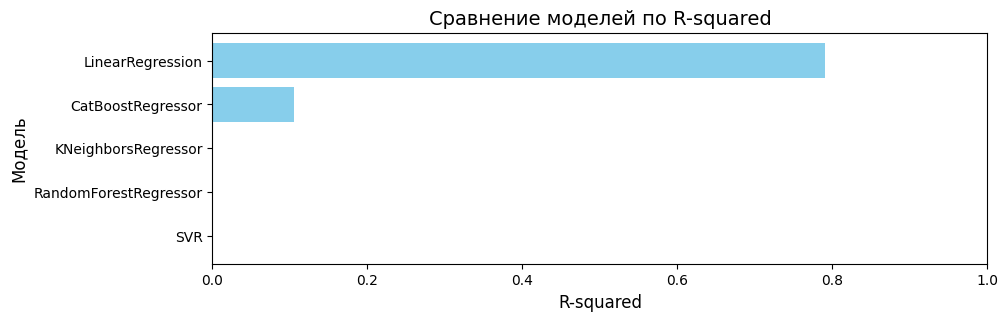

In [57]:
# Сортировка по R-квадрату для лучшей наглядности
results_df = results_df.sort_values(by='R-squared', ascending=False)

plt.figure(figsize=(10, 3))  # Размер графика
plt.barh(results_df['Model'], results_df['R-squared'], color='skyblue')
plt.xlabel('R-squared', fontsize=12)
plt.ylabel('Модель', fontsize=12)
plt.title('Сравнение моделей по R-squared', fontsize=14)
plt.xlim(0, 1)  # Ограничение оси X от 0 до 1 для R-квадрата
plt.gca().invert_yaxis()  # Инвертируем ось Y, чтобы лучшая модель была сверху
plt.show()

In [61]:
# подготовка данных
trg_lin = df_total[['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']]
trn_lin = df_total.drop('Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего', axis=1)

# разделение данных
Xtrn_lin, Xtest_lin, Ytrn_lin, Ytest_lin = train_test_split(trn, trg, test_size=0.2, random_state = 42)

# Создание и обучение модели
model = models[0]
model.fit(Xtrn, Ytrn)

# Предсказание и оценка
predictions1 = model.predict(Xtest)
print(predictions1)

[[ 968532.99264702]
 [1199074.07070708]
 [ 791992.53382352]
 [1755681.16620752]
 [1034735.66470587]]


In [ ]:
# Для красивой визуализации отсортируем данные по возрастанию фактических значений
sorted_indices1 = Ytest['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'].argsort()
Ytest_sorted1 = Ytest.iloc[sorted_indices1]
predictions_sorted1 = predictions1[sorted_indices1]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(Ytest_sorted.values, label='Фактические значения')
plt.plot(predictions_sorted, label='Предсказанные значения')
plt.xlabel('Индекс наблюдения (отсортированный)')
plt.ylabel('Объем кредитов, млн руб.')
plt.title('Сравнение предсказанных и фактических значений')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# подготовка данных
trg = df_total[['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего']]
trn = df_total.drop('Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего', axis=1)

# разделение данных
Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.2, random_state = 42)

# Создание и обучение модели
regressor = CatBoostRegressor(iterations=200, depth=4, learning_rate=0.01)
regressor.fit(Xtrn, Ytrn, verbose=False)

# Предсказание и оценка
predictions = regressor.predict(Xtest)
print(predictions)

[1023761.66029432 1017324.27538279 1108101.64955737 1375035.65511825
 1028902.98456526]


Метрики точности:

* R-squared (R²): Коэффициент детерминации, показывает долю дисперсии целевой переменной, объясненную моделью (от 0 до 1, чем ближе к 1, тем лучше).
* Mean Absolute Error (MAE):  Средняя абсолютная ошибка, показывает среднюю величину ошибки предсказания.
* Mean Squared Error (MSE):  Средняя квадратичная ошибка, чувствительна к большим ошибкам.
* Root Mean Squared Error (RMSE):  Корень из средней квадратичной ошибки, интерпретируется в тех же единицах, что и целевая переменная.

In [17]:
r2 = r2_score(Ytest, predictions)
mae = mean_absolute_error(Ytest, predictions)
mse = mean_squared_error(Ytest, predictions)
rmse = mean_squared_error(Ytest, predictions, squared=False)  # squared=False для RMSE

print(f"R-squared: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

R-squared: 0.22
MAE: 272939.61
MSE: 94076639454.21
RMSE: 306719.15


C:\Users\Дарья\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R-squared меньше 0,5 - у модели плохая точность

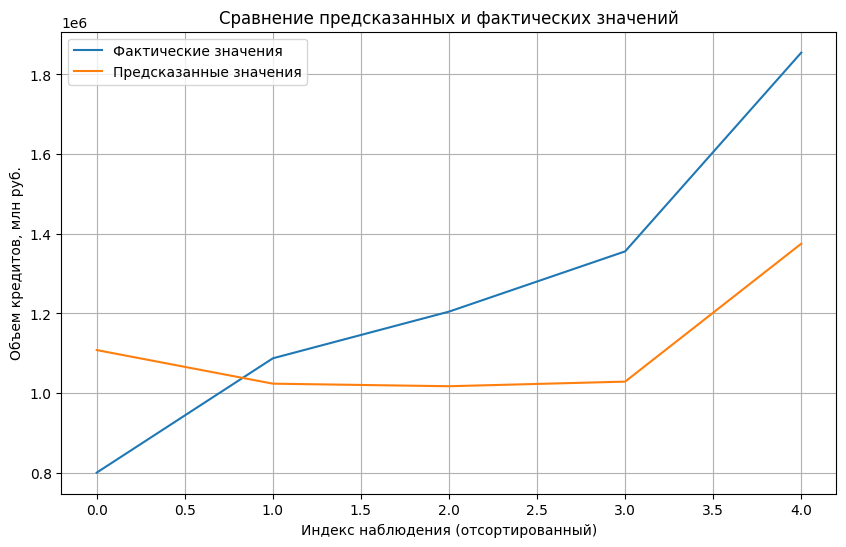

In [18]:
# Для красивой визуализации отсортируем данные по возрастанию фактических значений
sorted_indices = Ytest['Объем кредитов, предоставленных субъектам МСП, млн руб.<>всего'].argsort()
Ytest_sorted = Ytest.iloc[sorted_indices]
predictions_sorted = predictions[sorted_indices]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(Ytest_sorted.values, label='Фактические значения')
plt.plot(predictions_sorted, label='Предсказанные значения')
plt.xlabel('Индекс наблюдения (отсортированный)')
plt.ylabel('Объем кредитов, млн руб.')
plt.title('Сравнение предсказанных и фактических значений')
plt.legend()
plt.grid(True)
plt.show()

Выполним предсказание на 2025 год

In [19]:
predictions_2025 = regressor.predict(data_for_predict)
print(predictions)

[1023761.66029432 1017324.27538279 1108101.64955737 1375035.65511825
 1028902.98456526]


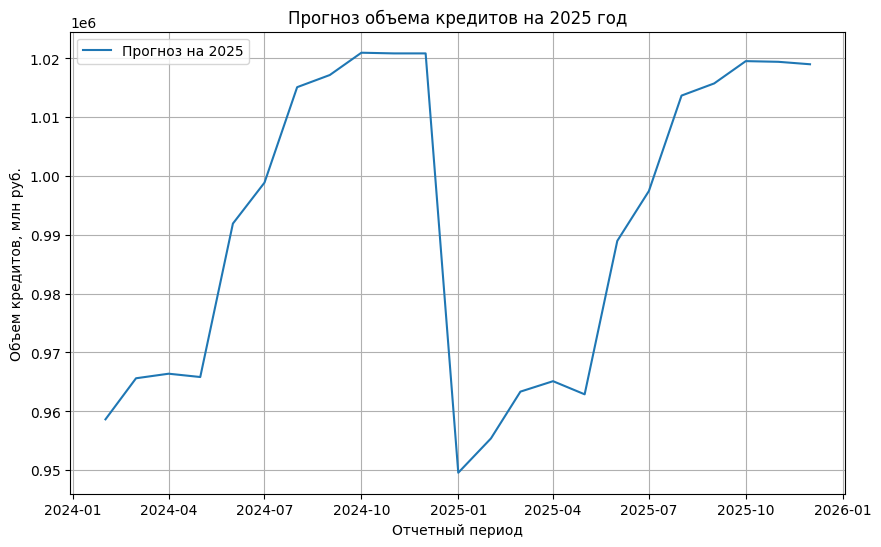

In [20]:
predictions_2025 = regressor.predict(data_for_predict)

plt.figure(figsize=(10, 6))
plt.plot(data_for_predict_in_memory['Отчетный период'], predictions_2025, label='Прогноз на 2025')
plt.xlabel('Отчетный период')
plt.ylabel('Объем кредитов, млн руб.')
plt.title('Прогноз объема кредитов на 2025 год')
plt.legend()
plt.grid(True)
plt.show() 